# Data Exploration
Initial exploration of SHED 2024, Regional Price Parities, and FRED minimum wage datasets

In [149]:
%pip install pandas numpy scikit-learn matplotlib seaborn plotly imbalanced-learn shap openpyxl -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully")

All libraries imported successfully


## Load Datasets

In [151]:
# Load datasets
fred = pd.read_csv("../data/raw/fredgraph.csv")
rpp = pd.read_excel("../data/raw/rpp1224.xlsx", skiprows=5)
shed = pd.read_csv("../data/raw/public2024.csv")

# Clean RPP data
rpp.columns = ['state', 'real_pce_2022', 'real_pce_2023', 'pce_pct_change',
               'real_income_2022', 'real_income_2023', 'income_pct_change']
rpp['state'] = rpp['state'].str.lower().str.strip()
rpp = rpp[~rpp['state'].isin(['united states', 'nan', ''])]
rpp = rpp.dropna(subset=['state'])

## Basic Dataset Information

In [152]:
print(f"FRED (Minimum Wage Data)")
print(f"Dataset shape: {fred.shape}")
print(f"Total samples: {len(fred):,}")
print(f"\nColumns: {fred.columns.tolist()}")

FRED (Minimum Wage Data)
Dataset shape: (58, 13)
Total samples: 58

Columns: ['observation_date', 'STTMINWGFG', 'STTMINWGAK', 'STTMINWGAR', 'STTMINWGAZ', 'STTMINWGCA', 'STTMINWGCO', 'STTMINWGCT', 'STTMINWGDE', 'STTMINWGFL', 'STTMINWGGA', 'STTMINWGHI', 'STTMINWGIA']


In [153]:
fred.head()

,observation_date,STTMINWGFG,STTMINWGAK,STTMINWGAR,STTMINWGAZ,STTMINWGCA,STTMINWGCO,STTMINWGCT,STTMINWGDE,STTMINWGFL,STTMINWGGA,STTMINWGHI,STTMINWGIA
0,1968-01-01,1.6,2.1,NaN,NaN,1.65,1.25,1.40,1.25,NaN,NaN,1.25,NaN
1,1969-01-01,1.6,2.1,NaN,NaN,1.65,1.25,1.40,1.25,NaN,NaN,1.25,NaN
2,1970-01-01,1.6,2.1,1.1,NaN,1.65,1.25,1.60,1.25,NaN,NaN,1.60,NaN
3,1971-01-01,1.6,2.1,1.1,NaN,1.65,1.25,1.60,1.25,NaN,NaN,1.60,NaN
4,1972-01-01,1.6,2.1,1.2,NaN,1.65,1.25,1.85,1.60,NaN,1.25,1.60,NaN


In [154]:
fred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  58 non-null     object 
 1   STTMINWGFG        58 non-null     float64
 2   STTMINWGAK        58 non-null     float64
 3   STTMINWGAR        56 non-null     float64
 4   STTMINWGAZ        19 non-null     float64
 5   STTMINWGCA        58 non-null     float64
 6   STTMINWGCO        58 non-null     float64
 7   STTMINWGCT        58 non-null     float64
 8   STTMINWGDE        58 non-null     float64
 9   STTMINWGFL        20 non-null     float64
 10  STTMINWGGA        52 non-null     float64
 11  STTMINWGHI        58 non-null     float64
 12  STTMINWGIA        35 non-null     float64
dtypes: float64(12), object(1)
memory usage: 6.0+ KB


In [155]:
print(f"SHED 2024 (Survey of Household Economics and Decisionmaking)")
print(f"Dataset shape: {shed.shape}")
print(f"Total samples: {len(shed):,}")
print(f"\nColumns: {len(shed.columns)} features")
print(f"\nFirst 20 columns: {shed.columns.tolist()[:20]}")

SHED 2024 (Survey of Household Economics and Decisionmaking)
Dataset shape: (12295, 753)
Total samples: 12,295

Columns: 753 features

First 20 columns: ['CaseID', 'caseid2023', 'caseid2022', 'duration', 'weight', 'weight_pop', 'panel_weight', 'panel_weight_pop', 'x2023', 'x2022', 'xlaptop', 'L0_a', 'L0_b', 'L0_c', 'L0_d', 'L0_e', 'L0B_a', 'L0B_b', 'L0B_c', 'L0C']


In [156]:
shed.head()

,CaseID,caseid2023,caseid2022,duration,weight,weight_pop,panel_weight,panel_weight_pop,x2023,x2022,...,E4_d_iflag,E4_e_iflag,E4_f_iflag,CH2A_iflag,race_5cat,inc_4cat_50k,educ_4cat,pay_casheqv,atleast_okay,control
0,1,1.0,1.0,1333,0.6149,12971.9817,1.2153,78509.7641,Yes,Yes,...,0,0,0,0,White,"$25,000–$49,999",Bachelor's degree or more,Yes,Yes,Public
1,2,NaN,2.0,975,0.8301,17511.2242,NaN,NaN,No,Yes,...,0,0,0,0,White,"$100,000 or more",Bachelor's degree or more,Yes,Yes,Public
2,3,7.0,NaN,2146,0.4447,9381.0980,0.8061,52078.4957,Yes,No,...,0,0,0,0,White,"$50,000–$99,999",Bachelor's degree or more,Yes,Yes,NaN
3,4,NaN,NaN,1214,0.8333,17580.0326,NaN,NaN,No,No,...,0,0,0,0,White,"$50,000–$99,999",High school degree or GED,Yes,Yes,NaN
4,5,NaN,9.0,1168,0.9064,19121.3763,NaN,NaN,No,Yes,...,0,0,0,0,White,"$50,000–$99,999",Some college/technical or associates degree,Yes,Yes,Public


In [157]:
shed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12295 entries, 0 to 12294
Columns: 753 entries, CaseID to control
dtypes: float64(24), int64(354), object(375)
memory usage: 70.6+ MB


In [158]:
print(f"RPP (Regional Price Parities)")
print(f"Dataset shape: {rpp.shape}")
print(f"Total samples: {len(rpp):,}")
print(f"\nColumns: {rpp.columns.tolist()}")

RPP (Regional Price Parities)
Dataset shape: (55, 7)
Total samples: 55

Columns: ['state', 'real_pce_2022', 'real_pce_2023', 'pce_pct_change', 'real_income_2022', 'real_income_2023', 'income_pct_change']


In [159]:
rpp.head()

,state,real_pce_2022,real_pce_2023,pce_pct_change,real_income_2022,real_income_2023,income_pct_change
0,arizona,321902.0,328923.0,2.2,374593.0,381769.0,1.9
1,arkansas,127802.0,130245.0,1.9,167212.0,169738.0,1.5
2,california,1815443.0,1862352.0,2.6,2300588.0,2335587.0,1.5
3,colorado,295601.0,306885.0,3.8,377586.0,385504.0,2.1
4,connecticut,179159.0,188561.0,5.2,248931.0,260583.0,4.7


In [160]:
rpp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 0 to 55
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              55 non-null     object 
 1   real_pce_2022      52 non-null     float64
 2   real_pce_2023      52 non-null     float64
 3   pce_pct_change     52 non-null     float64
 4   real_income_2022   52 non-null     float64
 5   real_income_2023   52 non-null     float64
 6   income_pct_change  52 non-null     float64
dtypes: float64(6), object(1)
memory usage: 3.4+ KB


## Statistical Summaries

In [161]:
fred.describe()

,STTMINWGFG,STTMINWGAK,STTMINWGAR,STTMINWGAZ,STTMINWGCA,STTMINWGCO,STTMINWGCT,STTMINWGDE,STTMINWGFL,STTMINWGGA,STTMINWGHI,STTMINWGIA
count,58.000000,58.000000,56.000000,19.000000,58.000000,58.000000,58.000000,58.000000,20.000000,52.000000,58.000000,35.000000
mean,4.636207,5.766207,4.945536,9.805263,6.013793,5.086552,6.028793,5.132759,8.521500,3.640000,5.496552,6.121429
std,2.011301,2.831142,2.893524,2.764100,3.982713,3.856311,3.819231,3.271200,1.789788,1.968085,3.238554,1.195229
min,1.600000,2.100000,1.100000,6.750000,1.650000,1.250000,1.400000,1.250000,6.400000,1.230000,1.250000,4.250000
25%,3.350000,3.850000,2.700000,7.500000,3.350000,1.900000,3.370000,2.000000,7.250000,1.250000,3.100000,5.150000
50%,4.500000,5.000000,4.700000,8.050000,4.500000,3.875000,4.520000,4.825000,8.050000,3.250000,5.250000,7.250000
75%,7.250000,7.750000,6.250000,12.075000,8.000000,7.340000,8.250000,7.250000,8.920000,5.150000,7.250000,7.250000
max,7.250000,11.910000,11.000000,14.700000,16.500000,14.810000,16.350000,15.000000,13.000000,7.250000,14.000000,7.250000


In [162]:
shed.describe()

,CaseID,caseid2023,caseid2022,duration,weight,weight_pop,panel_weight,panel_weight_pop,CG2,R3,...,E2_iflag,E2A_iflag,E2B_iflag,E4_a_iflag,E4_b_iflag,E4_c_iflag,E4_d_iflag,E4_e_iflag,E4_f_iflag,CH2A_iflag
count,12295.000000,4039.000000,3853.000000,1.229500e+04,12295.000000,12295.000000,4015.000000,4015.00000,483.000000,3201.000000,...,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000
mean,6383.407564,5549.327061,8957.120166,1.367906e+04,0.999998,21096.509312,1.000000,64603.13375,312.296066,1372.120587,...,0.003823,0.002196,0.003904,0.009028,0.016673,0.010655,0.019845,0.018788,0.017649,0.002440
std,3694.987134,3079.649241,10423.569397,6.477207e+04,0.435112,9179.335914,0.421962,27260.01214,357.599113,996.913249,...,0.061712,0.046812,0.062363,0.094590,0.128050,0.102675,0.139475,0.135782,0.131679,0.049338
min,1.000000,1.000000,1.000000,3.850000e+02,0.178800,3771.794000,0.094300,6094.60200,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3192.500000,2953.500000,3231.000000,9.940000e+02,0.716300,15111.396900,0.717700,46365.26360,101.500000,725.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6376.000000,5554.000000,6142.000000,1.319000e+03,0.924400,19502.656900,0.897800,57999.59550,225.000000,1200.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9575.500000,8072.500000,9162.000000,2.032000e+03,1.172700,24740.515400,1.220600,78854.04785,400.000000,1750.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12818.000000,11484.000000,48356.000000,1.038184e+06,3.515900,74172.699500,3.290200,212555.40500,4000.000000,9999.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [163]:
rpp.describe()

,real_pce_2022,real_pce_2023,pce_pct_change,real_income_2022,real_income_2023,income_pct_change
count,5.200000e+01,5.200000e+01,52.000000,5.200000e+01,5.200000e+01,52.000000
mean,3.578747e+05,3.670970e+05,2.832692,4.483747e+05,4.572462e+05,2.326923
std,4.471705e+05,4.592369e+05,1.942580,5.637163e+05,5.737723e+05,2.058470
min,2.940700e+04,3.038100e+04,-0.600000,3.514700e+04,3.724300e+04,-2.000000
25%,7.924050e+04,8.136175e+04,1.350000,9.954725e+04,1.013032e+05,1.075000
50%,1.973715e+05,2.021760e+05,2.350000,2.462990e+05,2.567945e+05,2.000000
75%,3.988410e+05,4.133185e+05,3.825000,5.173345e+05,5.331750e+05,3.725000
max,1.815443e+06,1.862352e+06,7.900000,2.300588e+06,2.335587e+06,8.000000


## Data Visualizations

### Target Variable Distribution

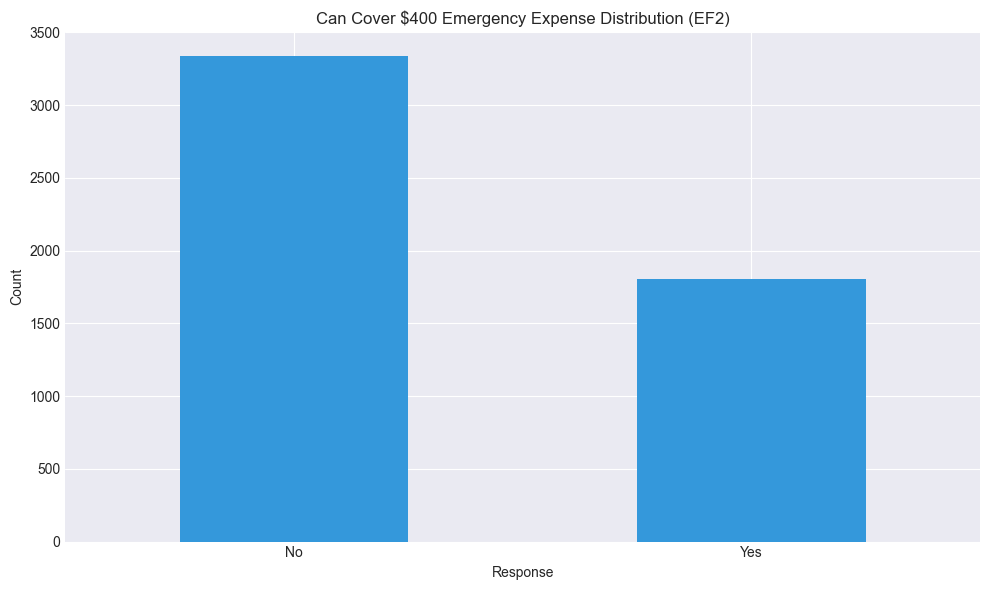


Percentage distribution:
EF2
No     64.871695
Yes    35.128305
Name: proportion, dtype: float64

Total responses: 5,144
Missing: 7,151


In [164]:
target_column = 'EF2'

if target_column in shed.columns:
    plt.figure(figsize=(10, 6))
    shed[target_column].value_counts().plot(kind='bar', color='#3498db')
    plt.title('Can Cover $400 Emergency Expense Distribution (EF2)')
    plt.xlabel('Response')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPercentage distribution:")
    print(shed[target_column].value_counts(normalize=True) * 100)
    print(f"\nTotal responses: {shed[target_column].notna().sum():,}")
    print(f"Missing: {shed[target_column].isna().sum():,}")
else:
    print(f"Column '{target_column}' not found. Check SHED codebook for correct column name.")

### Demographic Distributions

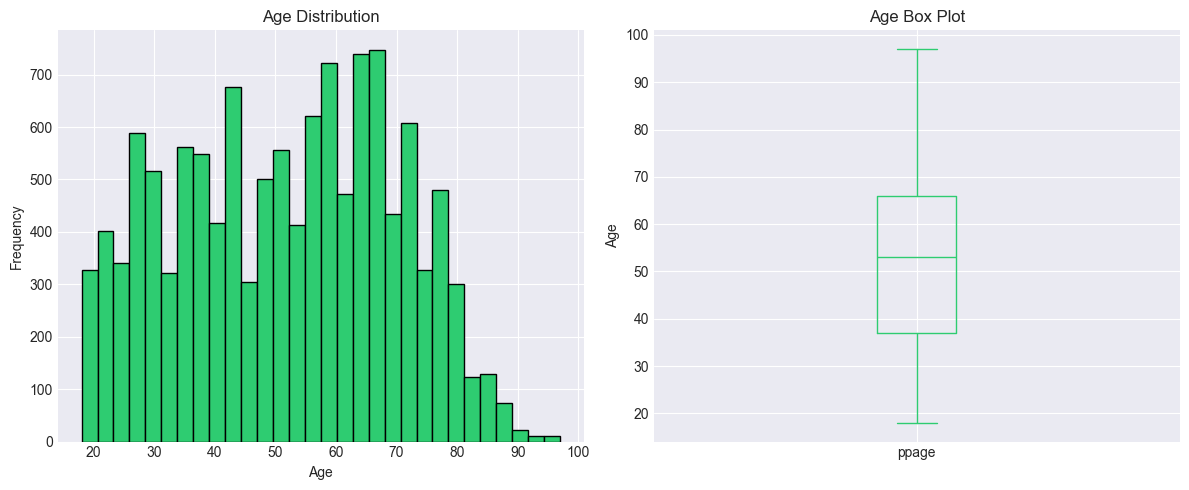

In [165]:
# Age distribution
if 'ppage' in shed.columns:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    shed['ppage'].hist(bins=30, color='#2ecc71', edgecolor='black')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    shed['ppage'].plot(kind='box', color='#2ecc71')
    plt.title('Age Box Plot')
    plt.ylabel('Age')
    
    plt.tight_layout()
    plt.show()

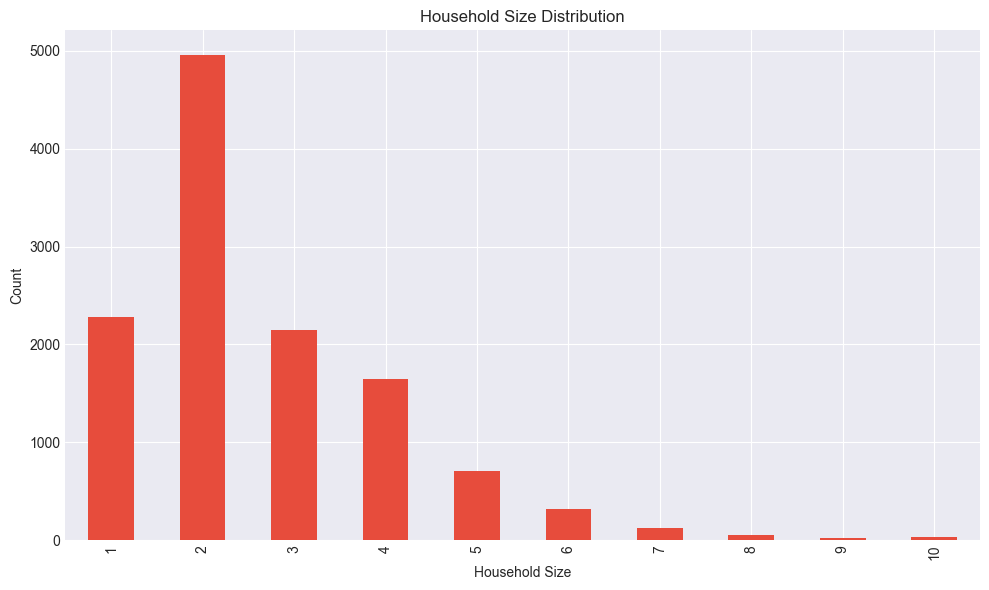

In [166]:
# Household size distribution
if 'pphhsize' in shed.columns:
    plt.figure(figsize=(10, 6))
    shed['pphhsize'].value_counts().sort_index().plot(kind='bar', color='#e74c3c')
    plt.title('Household Size Distribution')
    plt.xlabel('Household Size')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

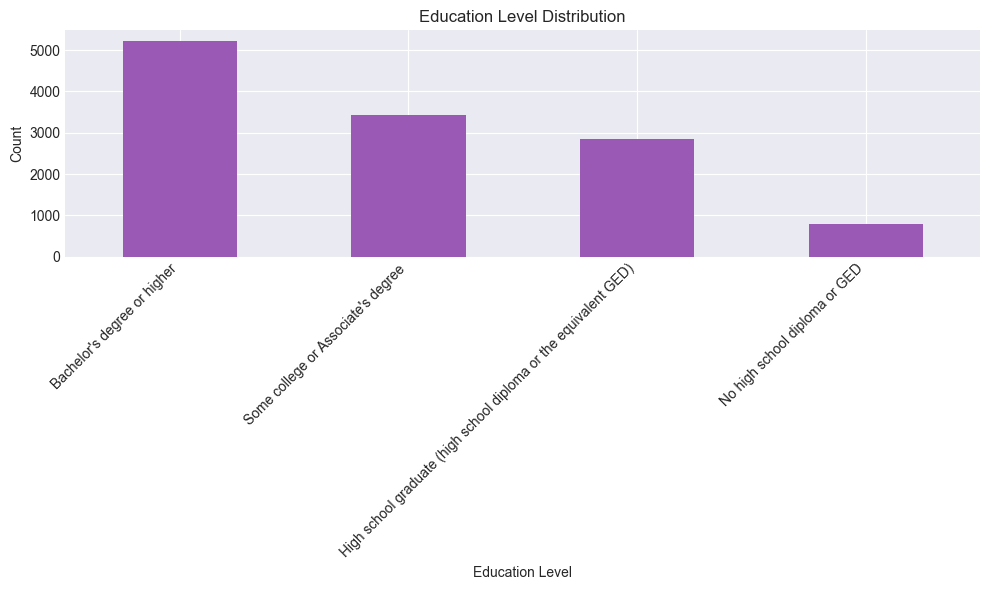

In [167]:
# Education level distribution
if 'ppeducat' in shed.columns:
    plt.figure(figsize=(10, 6))
    shed['ppeducat'].value_counts().plot(kind='bar', color='#9b59b6')
    plt.title('Education Level Distribution')
    plt.xlabel('Education Level')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Geographic Analysis

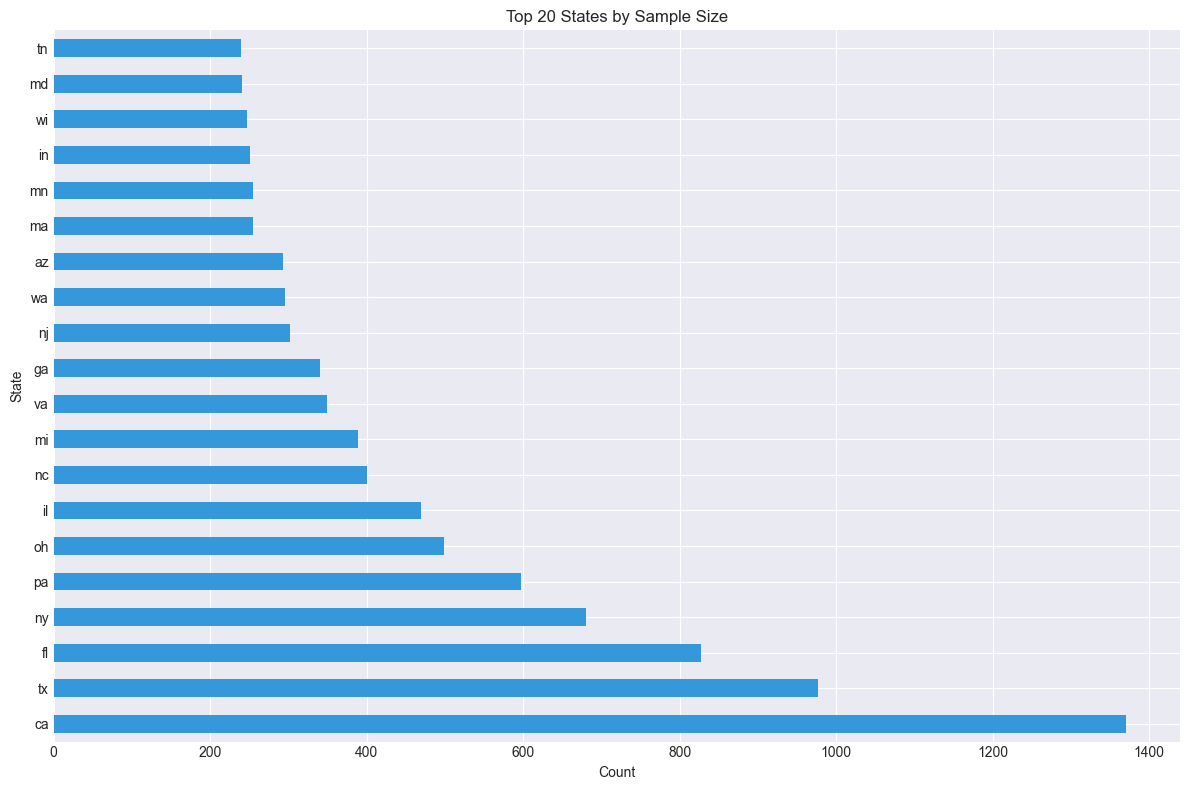

In [168]:
# State distribution in SHED data
if 'ppstaten' in shed.columns:
    plt.figure(figsize=(12, 8))
    state_counts = shed['ppstaten'].value_counts().head(20)
    state_counts.plot(kind='barh', color='#3498db')
    plt.title('Top 20 States by Sample Size')
    plt.xlabel('Count')
    plt.ylabel('State')
    plt.tight_layout()
    plt.show()

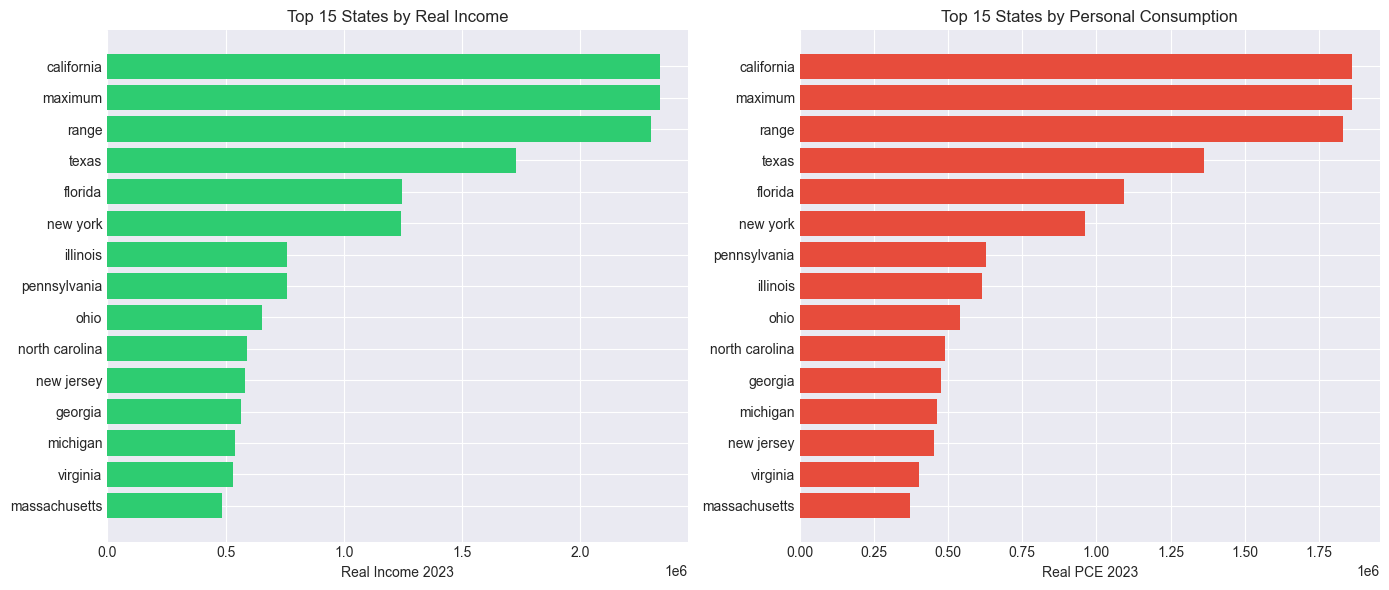

In [169]:
# Regional Price Parities visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
top_income = rpp.nlargest(15, 'real_income_2023')
plt.barh(range(len(top_income)), top_income['real_income_2023'], color='#2ecc71')
plt.yticks(range(len(top_income)), top_income['state'])
plt.xlabel('Real Income 2023')
plt.title('Top 15 States by Real Income')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
top_pce = rpp.nlargest(15, 'real_pce_2023')
plt.barh(range(len(top_pce)), top_pce['real_pce_2023'], color='#e74c3c')
plt.yticks(range(len(top_pce)), top_pce['state'])
plt.xlabel('Real PCE 2023')
plt.title('Top 15 States by Personal Consumption')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### Correlation Analysis

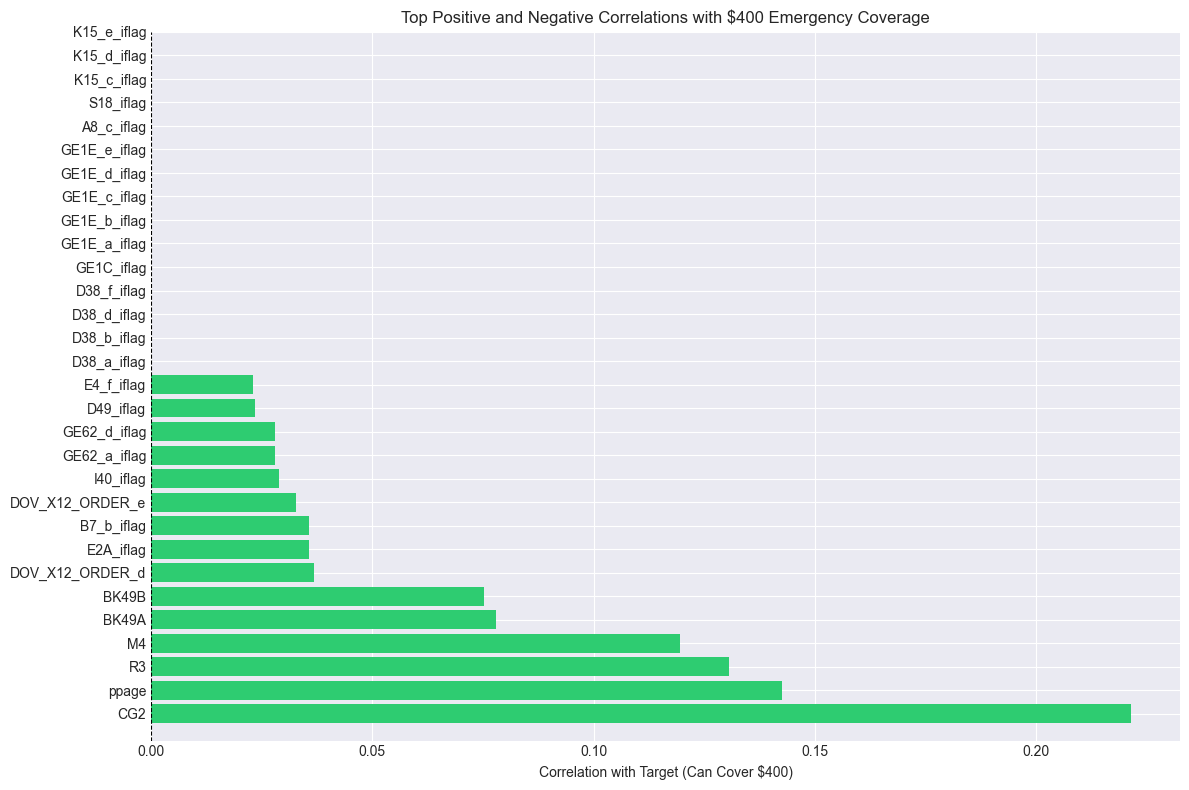


Top 10 Positive Correlations:
CG2                0.221486
ppage              0.142489
R3                 0.130687
M4                 0.119621
BK49A              0.078008
BK49B              0.075282
DOV_X12_ORDER_d    0.036930
E2A_iflag          0.035728
B7_b_iflag         0.035678
DOV_X12_ORDER_e    0.032643
Name: can_cover_400_numeric, dtype: float64

Top 10 Negative Correlations:
GE1E_a_iflag   NaN
GE1E_b_iflag   NaN
GE1E_c_iflag   NaN
GE1E_d_iflag   NaN
GE1E_e_iflag   NaN
A8_c_iflag     NaN
S18_iflag      NaN
K15_c_iflag    NaN
K15_d_iflag    NaN
K15_e_iflag    NaN
Name: can_cover_400_numeric, dtype: float64


In [170]:
shed['can_cover_400_numeric'] = shed[target_column].map({'Yes': 1, 'No': 0})

numeric_cols = shed.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation with target variable
if 'can_cover_400_numeric' in shed.columns and shed['can_cover_400_numeric'].notna().any():
    correlations = shed[numeric_cols].corr()['can_cover_400_numeric'].sort_values(ascending=False)
    correlations = correlations[correlations.index != 'can_cover_400_numeric']
    
    plt.figure(figsize=(12, 8))
    top_positive = correlations.head(15)
    top_negative = correlations.tail(15)
    top_corr = pd.concat([top_positive, top_negative])
    
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_corr]
    plt.barh(range(len(top_corr)), top_corr, color=colors)
    plt.yticks(range(len(top_corr)), top_corr.index)
    plt.xlabel('Correlation with Target (Can Cover $400)')
    plt.title('Top Positive and Negative Correlations with $400 Emergency Coverage')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Positive Correlations:")
    print(correlations.head(10))
    print("\nTop 10 Negative Correlations:")
    print(correlations.tail(10))
else:
    print("Cannot compute correlations - target variable not available")

### Missing Data Analysis

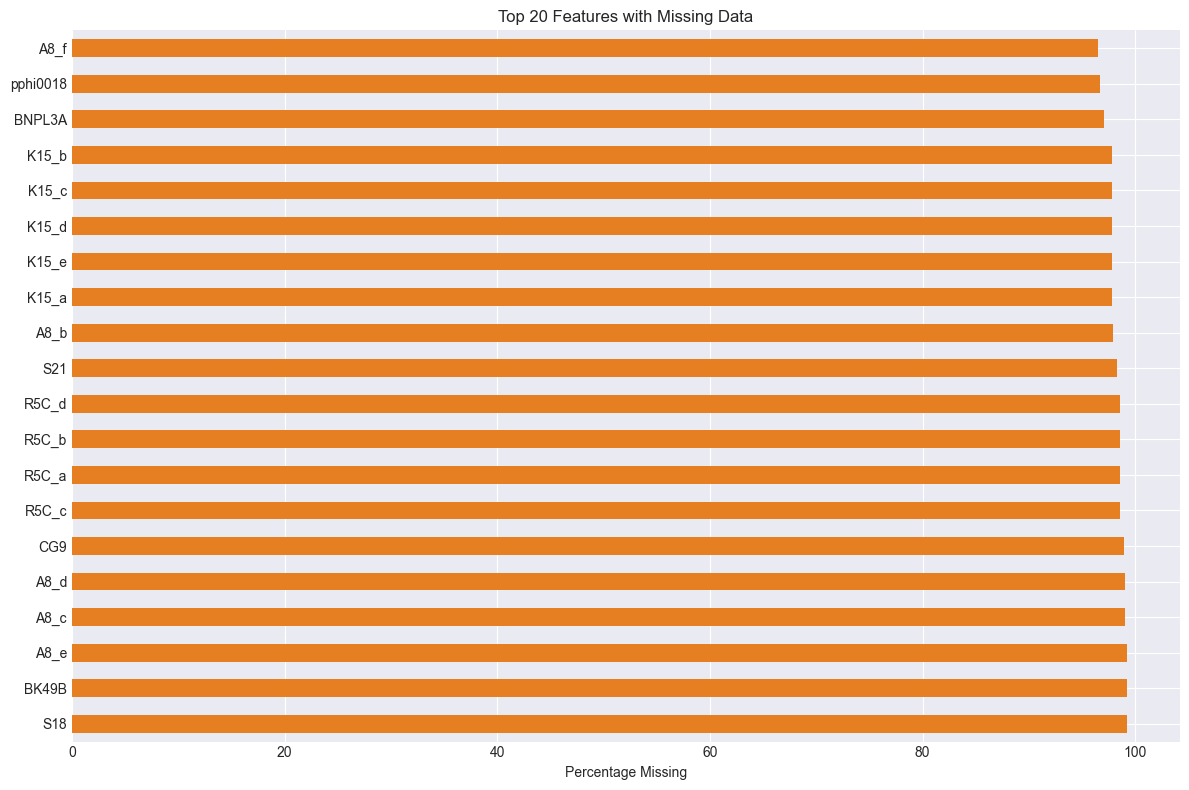


Total features with missing data: 257

Top 10 features with most missing data:
S18      99.251728
BK49B    99.202928
A8_e     99.194795
A8_c     99.056527
A8_d     99.032127
CG9      98.918259
R5C_c    98.576657
R5C_a    98.576657
R5C_b    98.576657
R5C_d    98.576657
dtype: float64


In [171]:
# Calculate missing percentages
missing_pct = (shed.isnull().sum() / len(shed)) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

if len(missing_pct) > 0:
    plt.figure(figsize=(12, 8))
    missing_pct.head(20).plot(kind='barh', color='#e67e22')
    plt.xlabel('Percentage Missing')
    plt.title('Top 20 Features with Missing Data')
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal features with missing data: {len(missing_pct)}")
    print(f"\nTop 10 features with most missing data:")
    print(missing_pct.head(10))
else:
    print("No missing data found in SHED dataset")

## Summary Statistics

Key findings from data exploration will inform preprocessing and feature selection.

In [172]:
print("=" * 80)
print("DATA EXPLORATION SUMMARY")
print("=" * 80)
print(f"\nSHED Dataset:")
print(f"  - Total respondents: {len(shed):,}")
print(f"  - Total features: {len(shed.columns)}")
print(f"  - Numeric features: {len(shed.select_dtypes(include=[np.number]).columns)}")
print(f"  - Categorical features: {len(shed.select_dtypes(include=['object']).columns)}")

print(f"\nRPP Dataset:")
print(f"  - States covered: {len(rpp)}")
print(f"  - Average income change: {rpp['income_pct_change'].mean():.2f}%")
print(f"  - Average PCE change: {rpp['pce_pct_change'].mean():.2f}%")

print(f"\nFRED Dataset:")
print(f"  - Records: {len(fred):,}")
print(f"  - Features: {len(fred.columns)}")

print("\n" + "=" * 80)
print("Ready to proceed to preprocessing notebook")
print("=" * 80)

DATA EXPLORATION SUMMARY

SHED Dataset:
  - Total respondents: 12,295
  - Total features: 754
  - Numeric features: 379
  - Categorical features: 375

RPP Dataset:
  - States covered: 55
  - Average income change: 2.33%
  - Average PCE change: 2.83%

FRED Dataset:
  - Records: 58
  - Features: 13

Ready to proceed to preprocessing notebook
